In [10]:
%matplotlib inline 

import six
import Quandl
import calendar
import math
import numpy as np
import pandas as pd
import seaborn as sb
import pylab as pylab
from datetime import datetime

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal
import statsmodels.api as sm 
import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, ensemble
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import preprocessing

import sys
from os import listdir
from os.path import isfile, join
from helpers import features_analysis, procces_stocks, data_manipulation, download_quandl_data, ml_dataset
from classes import Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')


In [11]:

GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
OIL_BRENT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'OIL_BRENT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, OIL_BRENT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD_AM', 'USD', 'USD_AM', 'USD', 'Open', 'Open', 'Open', 'Open', 'Open']
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date']]
    #new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]    
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)
datasetY = dataset.copy(deep=True)
#dataset = dataset.fillna(method='ffill')

In [12]:
def remove_columns_from_dataset(dataset, predicting='close', shifted = False):
    """
    """

    ###########################
    # predicting close price: #
    ###########################        
    colsToRemove = []
    colsToShift = []
    
    if predicting == 'close':
        if not shifted:        
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'GOLD' in col and not '_AM' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SILVER' in col and not '_USD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'OIL_BRENT' in col and not '_USD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'PLAT' in col and not '_AM' in col])
            colsToRemove.extend([col for col in dataset.columns if 'DJIA' in col and not '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'HSI' in col and '_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'IBEX' in col and not '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SP500' in col and not '_Open' in col])
            colsToRemove.remove('IBEX_RD_B1_Close')            
        else:
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])            
            colsToShift.extend([col for col in dataset.columns if 'GOLD' in col and not '_AM' in col])
            colsToShift.extend([col for col in dataset.columns if 'SILVER' in col and not '_USD' in col])
            colsToShift.extend([col for col in dataset.columns if 'OIL_BRENT' in col and not '_USD' in col])
            colsToShift.extend([col for col in dataset.columns if 'PLAT' in col and not '_AM' in col])
            colsToShift.extend([col for col in dataset.columns if 'DJIA' in col and not '_Open' in col])
            colsToShift.extend([col for col in dataset.columns if 'HSI' in col and '_Date' in col])
            colsToShift.extend([col for col in dataset.columns if 'IBEX' in col and not '_Open' in col])
            colsToShift.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToShift.extend([col for col in dataset.columns if 'SP500' in col and not '_Open' in col])
            colsToShift.remove('IBEX_RD_B1_Close')  

    ###########################
    # predicting open price: #
    ###########################

    if predicting == 'open' and not shifted:            
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'GOLD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SILVER' in col])
            colsToRemove.extend([col for col in dataset.columns if 'PLAT' in col])
            colsToRemove.extend([col for col in dataset.columns if 'OIL_BRENT' in col])    
            colsToRemove.extend([col for col in dataset.columns if 'DJIA' in col])
            colsToRemove.extend([col for col in dataset.columns if 'HSI' in col and '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'IBEX' in col])
            colsToRemove.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SP500' in col])
            colsToRemove.remove('IBEX_RD_B1_Open')

    colsToShift = list(set(colsToShift) - set(colsToRemove)) 
    df = dataset.drop(colsToRemove, axis = 1)
    if shifted: 
        df[colsToShift] = df[colsToShift].shift(1)
        df = df[1:]
        df = df.reset_index(drop=True)
    
    return df

def dataset_to_train_using_dates(dataset, trainDates, testDates, predicting = 'close', binary = False, shiftFeatures = False, shiftTarget = False):
    """
    
    Parameter
    ---------------------
    - dataset: dataframe containing all available columns for a set of dates
    - trainDates: list containing the start training day and end training day
    - testDates: list containing the start training day and end testing day
    - namesToRemove: partial names to search to remove those columns
    - colY: name of target
    - binary: boolean detemines whether features will be binary only 
    - shifted: boolean detemines whether rows will be shifted by one

    """
    
    if shiftFeatures==True and shiftTarget==True:
        raise ValueError("Features and Target cannot be shifted at the same time")
        
    #dataset = remove_columns_from_dataset(dataset, predicting = predicting, shifted = shiftFeatures)
    #dataset = dataset[['GOLD_RD_B1_USD_AM','SILVER_RD_B1_USD','PLAT_RD_B1_USD_AM','OIL_BRENT_RD_B1_USD','DJIA_RD_B1_Open','HSI_RD_B1_Open','IBEX_RD_B1_Open','IBEX_RD_B1_Close','N225_RD_B1_Open','SP500_RD_B1_Open']]
    dataset = dataset[[col for col in dataset.columns if '_P' in col and 'Open' in col or 'IBEX_RD_B1_Close' in col]]
    ###########################
    # predicting close price: #
    ###########################    
    colY = ''
    colsToRemove = []

    if predicting == 'close': 
        colY = 'IBEX_RD_B1_Close'
        colsToRemove = ['IBEX_RD_B1_Close']
    if predicting == 'open': 
        colY = 'IBEX_RD_B1_Open'
        colsToRemove = ['IBEX_RD_B1_Close', 'IBEX_RD_B1_Open']

    train_df = dataset.iloc[trainDates[0]:trainDates[1]+1,]    
    test_df = dataset.iloc[testDates[0]:testDates[1]+1,]
        
    if binary:        
        colsToRemove.extend([col for col in dataset.columns if '_B' not in col])
        colsToRemove = list(set(colsToRemove))
        trainX = np.nan_to_num(np.asarray(train_df.drop(colsToRemove, axis = 1)))
        testX = np.nan_to_num(np.asarray(test_df.drop(colsToRemove, axis = 1)))        
    else:        
        colsToRemove = list(set(colsToRemove))
        trainX = np.nan_to_num(np.asarray(train_df.drop(colsToRemove, axis = 1)))
        testX = np.nan_to_num(np.asarray(test_df.drop(colsToRemove, axis = 1)))

    if shiftTarget:        
        trainY = np.nan_to_num(np.asarray(train_df[colY].shift(1)))[:]
        testY = np.nan_to_num(np.asarray(test_df[colY].shift(1)))[:]
        trainX = trainX[1:]
        testX = testX[1:]
    else:
        if shiftFeatures:
            trainY = np.nan_to_num(np.asarray(train_df[colY].shift(-1)))
            testY = np.nan_to_num(np.asarray(test_df[colY].shift(-1)))
            trainX = trainX[1:-1,1:-1]
            trainY = trainY[1:-1]
            testX = testX[1:-1,1:-1]
            testY = testY[1:-1]
        else:
            trainY = np.nan_to_num(np.asarray(train_df[colY]))
            testY = np.nan_to_num(np.asarray(test_df[colY]))

    #df = df.drop(dataset.index[-1,], axis=0)

    columns_names = dataset.drop(colsToRemove, axis=1).columns.values

    return trainX, trainY, testX, testY, columns_names, dataset

In [64]:
#[col for col in dataset.columns if '_P' in col and 'Open' in col or 'IBEX_RD_B1_Close' in col]

In [84]:
#training_dates = Iteration.Iteration('2010-08-19', '2016-04-08')
training_dates = Iteration.Iteration('1993-08-19', '2016-01-04')
testing_dates  = Iteration.Iteration('2016-01-05', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)

trainX, trainY, testX, testY, cols, new_dataset = dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=False, shiftTarget=False)
print "%s %s %s %s" % (trainX.shape,trainY.shape,testX.shape,testY.shape)

from sklearn import neighbors
#svc = neighbors.KNeighborsClassifier()
#svc = svm.SVC(decision_function_shape='ovr')
svc = ensemble.RandomForestClassifier(n_estimators=200)

svc.fit(trainX, trainY)
prediction = svc.predict(testX)
fpr, tpr, _ = metrics.roc_curve(testY, prediction)
print "> AUC: %.4f " % metrics.auc(fpr, tpr)
print "> Score: %.4f " % svc.score(testX, testY)
print metrics.classification_report(testY, prediction)

(5635, 20) (5635,) (74, 20) (74,)
> AUC: 0.6596 
> Score: 0.6622 
             precision    recall  f1-score   support

          0       0.62      0.64      0.63        33
          1       0.70      0.68      0.69        41

avg / total       0.66      0.66      0.66        74



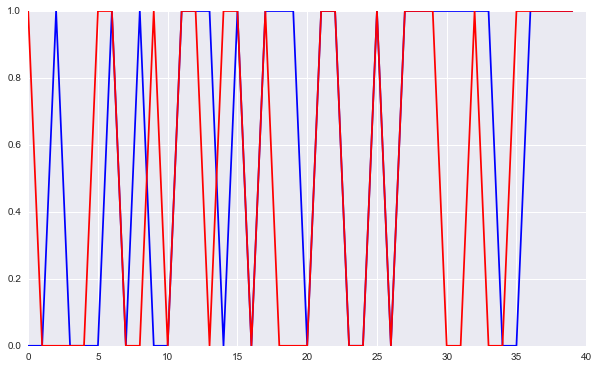

In [85]:
cv_preds = prediction
cv_preds[cv_preds >= 0.5] = 1
ones = np.where(cv_preds == 1)
cv_preds[cv_preds < 0.5] = 0
zeros = np.where(cv_preds == 0)

plt.figure()
plt.plot(cv_preds[0:40], c='blue')
plt.plot(testY[0:40], c='red')
plt.show()

In [49]:
from sklearn import neighbors
#svc = neighbors.KNeighborsClassifier()
#svc = svm.SVC(decision_function_shape='ovr')
svc = ensemble.RandomForestClassifier(n_estimators=200)

svc.fit(trainX, trainY)
prediction = svc.predict(testX)
fpr, tpr, _ = metrics.roc_curve(testY, prediction)
print "> AUC: %.4f " % metrics.auc(fpr, tpr)
print "> Score: %.4f " % svc.score(testX, testY)
print metrics.classification_report(testY, prediction)

> AUC: 0.4286 
> Score: 0.7500 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.86      0.86      0.86         7

avg / total       0.75      0.75      0.75         8



In [20]:
# Support Vector Machine
from sklearn import datasets

# load the iris datasets
dataset = datasets.load_iris()
# fit a SVM model to the data
model = svm.SVC()
model.fit(dataset.data, dataset.target)
print(model)
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print dataset.data.dtype
print dataset.target.dtype

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

[[50  0  0]
 [ 0 48  2]
 [ 0  0 50]]
float64
int64


In [27]:
#data_manipulation.write_csv_data(GOLD_new2, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER_new2, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT_new2, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(OIL_BRENT_new2, '/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA_new2, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI_new2, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX_new2, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225_new2, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500_new2, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')